## Lab 2
#### Marco Zuñiga


### Anomaly Detection

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
### import data
# from google.colab import drive
# drive.mount('/content/drive')


In [3]:
X = pd.read_csv('./estaturas.csv')
X_test_norm = pd.read_csv('./estaturas_test.csv')
X_test_anomalies = pd.read_csv('./estaturas_anomalies.csv')

X.columns =["height", "age"]
X_test_norm.columns =["height", "age"]
X_test_anomalies.columns =["height", "age"]

X_test_norm["Y"] = 0
X_test_anomalies["Y"] = 1

In [4]:
random_state = 5
X_norm_val, X_norm_test = train_test_split(X_test_norm, test_size=0.5, random_state=random_state)
X_anom_val, X_anom_test = train_test_split(X_test_anomalies, test_size=0.5, random_state=random_state)


X_val = X_norm_val.append(X_anom_val, ignore_index=True)
X_test = X_norm_test.append(X_anom_test, ignore_index=True)


In [5]:
#### EDA 

X.describe()

,height,age
count,44.000000,44.000000
mean,1.733864,29.590909
std,0.076833,6.855038
min,1.550000,21.000000
25%,1.675000,25.000000
50%,1.730000,27.000000
75%,1.782500,33.250000
max,1.900000,53.000000


In [6]:
X_val

,height,age,Y
0,1.82,25.0,0
1,1.76,32.0,0
2,1.79,31.0,0
3,1.60,35.0,0
4,0.15,250.0,1
5,150.00,14.0,1


In [7]:
X_test

,height,age,Y
0,1.61,31.0,0
1,1.60,31.0,0
2,1.82,30.0,0
3,1.80,27.0,0
4,0.25,2.4,1
5,175.10,2.5,1


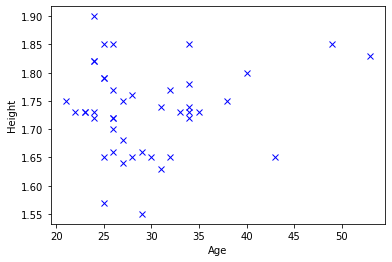

In [8]:
plt.xlabel('Age')
plt.ylabel('Height')
plt.plot(X["age"],X["height"],'bx')
plt.show()

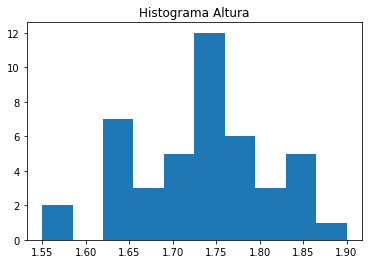

In [9]:
plt.hist(X['height'])
plt.title("Histograma Altura")
plt.show()

In [10]:
def estimate_gausian(data):
  mu = np.mean(data, axis=0)
  sigma = np.cov(data.T)
  return data, mu, sigma

def get_mv_gaussian(data, mu, sigma):
  p = multivariate_normal(mean=mu, cov=sigma)
  return data, p, p.pdf(data)

def select_treshhold(probs, y):
  best_eps = best_score = f = 0
  step = (np.max(probs) - np.min(probs)) / 1000
  epsilons = np.arange(np.min(probs),np.max(probs),step)
  for eps in np.nditer(epsilons):
    pred = (probs < eps)
    f = f1_score(y, pred, average='binary')
    if f > best_score:
      best_score = f
      best_eps = eps
  return best_eps, best_score

def predict_anomalies(data, model, eps):
  probs = model.pdf(data)
  # return the indices of the anomalies
  return probs, np.argwhere(probs < eps)
  

In [11]:
_, p, probs = get_mv_gaussian(*estimate_gausian(X))
probs



array([0.22856213, 0.29869155, 0.21861121, 0.21786979, 0.14733967,
       0.19213587, 0.14192005, 0.08897114, 0.07341122, 0.12870825,
       0.19160514, 0.17189088, 0.09981304, 0.1473954 , 0.17189088,
       0.23900461, 0.24884721, 0.02943121, 0.17850658, 0.27435819,
       0.26253168, 0.07828903, 0.06498756, 0.09981304, 0.14387197,
       0.24575252, 0.01682808, 0.27682344, 0.22981883, 0.16428003,
       0.26483066, 0.01533041, 0.2483547 , 0.2678488 , 0.00067169,
       0.16790953, 0.21850016, 0.16440648, 0.19160514, 0.01710575,
       0.26483066, 0.11274156, 0.22062902, 0.00299751])

In [12]:
probs_cv = p.pdf(X_val[["height", "age"]])
probs_cv

array([0.11425346, 0.27518305, 0.2327378 , 0.03838091, 0.        ,
       0.        ])

In [13]:
eps, score = select_treshhold(probs_cv, X_val["Y"])
eps, score

(array(0.00027518), 1.0)

In [14]:
#### Test

probs_test, idx = predict_anomalies(X_test[["height", "age"]], p, eps)
idx = idx.reshape(-1)

X_test.iloc[idx]

,height,age,Y
4,0.25,2.4,1
5,175.10,2.5,1


### PCA

In [15]:
from tensorflow import keras
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE

In [38]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train, train_y), (x_test, test_y) = fashion_mnist.load_data()

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [42]:
### Normalize Data


### transform images matrix 28x28
def transform_and_scale(imgs):
  res = imgs.reshape(-1, 28*28)
  return scale(res)

x_transfromed = transform_and_scale(np.concatenate((x_train, x_test), axis = 0))
y_all = np.concatenate((train_y, test_y), axis=0)

In [18]:
def pca(data, components):
  sigma = np.cov(data, rowvar=False)
  u, s, vh = np.linalg.svd(sigma, full_matrices=True)
  u_reduc = u[:, :components]
  print(s[:5], np.sum(s[:components]), np.sum(s))
  variance = np.sum(s[:components]) / np.sum(s)
  z = np.matmul(data, u_reduc)
  return z, variance, u_reduc


In [19]:
z, variance, u_reduc = pca(x_transfromed, 2)
variance

[173.20604322 112.9180361   42.83391428  39.90549263  31.79306016] 286.1240793231449 784.0112001600053


0.36494896917894937

In [20]:
z

array([[  0.82469513, -20.86260448],
       [-17.07338982,   4.96621704],
       [  9.60003596,  12.32192784],
       ...,
       [  6.99353047,   8.48864653],
       [  2.8922854 ,  15.3764669 ],
       [ 17.53224758,  -0.12483318]])

In [21]:
z.shape

(70000, 2)

In [22]:
u_reduc.shape

(784, 2)

### TSNE

In [25]:
t_model = TSNE(n_components=2, verbose=1)
X_embedded = t_model.fit_transform(x_transfromed)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 70000 samples in 0.066s...
[t-SNE] Computed neighbors for 70000 samples in 126.777s...
[t-SNE] Computed conditional probabilities for sample 1000 / 70000
[t-SNE] Computed conditional probabilities for sample 2000 / 70000
[t-SNE] Computed conditional probabilities for sample 3000 / 70000
[t-SNE] Computed conditional probabilities for sample 4000 / 70000
[t-SNE] Computed conditional probabilities for sample 5000 / 70000
[t-SNE] Computed conditional probabilities for sample 6000 / 70000
[t-SNE] Computed conditional probabilities for sample 7000 / 70000
[t-SNE] Computed conditional probabilities for sample 8000 / 70000
[t-SNE] Computed conditional probabilities for sample 9000 / 70000
[t-SNE] Computed conditional probabilities for sample 10000 / 70000
[t-SNE] Computed conditional probabilities for sample 11000 / 70000
[t-SNE] Computed conditional probabilities for sample 12000 / 70000
[t-SNE] Computed conditional probabilities for s

In [26]:
X_embedded.shape

(70000, 2)

In [30]:
t_model.kl_divergence_

3.0555174350738525

In [31]:
X_embedded

array([[-43.022713 ,  -2.472753 ],
       [ 34.76571  ,  18.361765 ],
       [ 15.049817 ,  -7.1847634],
       ...,
       [ 37.497147 ,  27.626123 ],
       [ 31.09285  , -37.88128  ],
       [-20.754808 , -22.905197 ]], dtype=float32)

In [47]:
labels= {0:"T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
mapped_labels =  list(map(lambda i: labels.get(i), y_all))


#### Plot Embedding

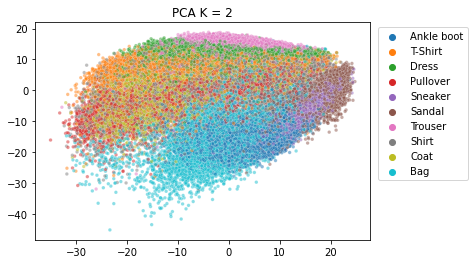

In [56]:
sns.scatterplot(x = z[:,0], y = z[:,1], hue = mapped_labels, s = 12, alpha = 0.5)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.title("PCA K = 2")
plt.show()

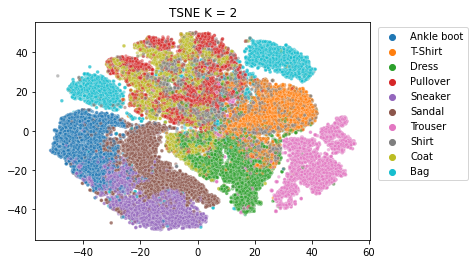

In [57]:
sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue = mapped_labels, s = 12, alpha = 0.5)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.title("TSNE K = 2")
plt.show()

TSNE mantiene una separacion de grupos mayor. Permitiendo diferenciar en la visualizacion mas cada uno de los tipos de etiqueta. Y por lo tanto generando una mejor representacion en 2D.

### Clustering with KMeans

In [61]:
from sklearn.cluster import KMeans

In [63]:
kmean_10 = KMeans(n_clusters = 10)
y_hat = kmean_10.fit_predict(X_embedded)

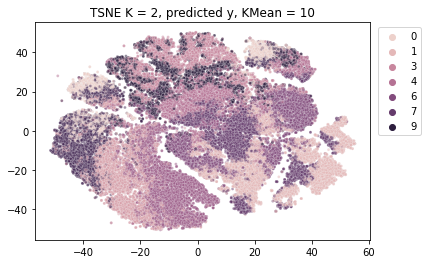

In [76]:
sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue = y_hat, s = 8, alpha = 0.5)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.title("TSNE K = 2, predicted y, KMean = 10")
plt.show()

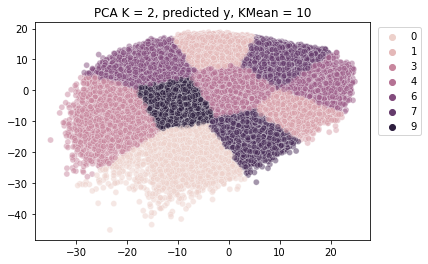

In [68]:
y_hat = kmean_10.fit_predict(z)
sns.scatterplot(x = z[:,0], y = z[:,1], hue = y_hat, s=8, alpha = 0.5)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.title("PCA K = 2, predicted y, KMean = 10")
plt.show()

Los clusters encontrados sobre el embedding de TSNE tienen una forma similar a las etiquetas reales del conjunto de datos. En cambio en PCA los clusters encontrados por KMeans no se parecen a los grupos reales que representan los puntos. 